# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB



from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [3]:
def add_features(df):
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)
    df['blueHerald'] = (df['blueEliteMonsters'] - df['blueDragons']).clip(lower=0)
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']
    df['dragonKillImpact'] = df['blueDragons'] / (df['blueKills'] + 1)
    df['eliteMonsterUtilization'] = df['blueEliteMonsters'] / (df['blueKills'] + df['blueAssists'] + 1)
    df['goldExperienceRatio'] = df['blueTotalGold'] / (df['blueTotalExperience'] + 1)
    df['teamEfficiency'] = (df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']) / (df['blueDeaths'] + 1)
    df['killToMonsterRatio'] = df['blueKills'] / (df['blueEliteMonsters'] + 1)
    df['avgGoldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)
    df['expToKillRatio'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killsMinusDeaths'] = df['blueKills'] - df['blueDeaths']
    df['killDeathRatio'] = df['blueKills'] / (df['blueKills'] + df['blueDeaths'])
    df['avgExperiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killDeathDiff'] = (df['blueKills'] - df['blueDeaths']).clip(lower=0)
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)
    df['goldXexperience'] = np.log1p(df['blueTotalGold'] * df['blueTotalExperience'])
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    
    return df

- Apply data

In [4]:
train = add_features(train)
test = add_features(test)

# 特徴量の効き

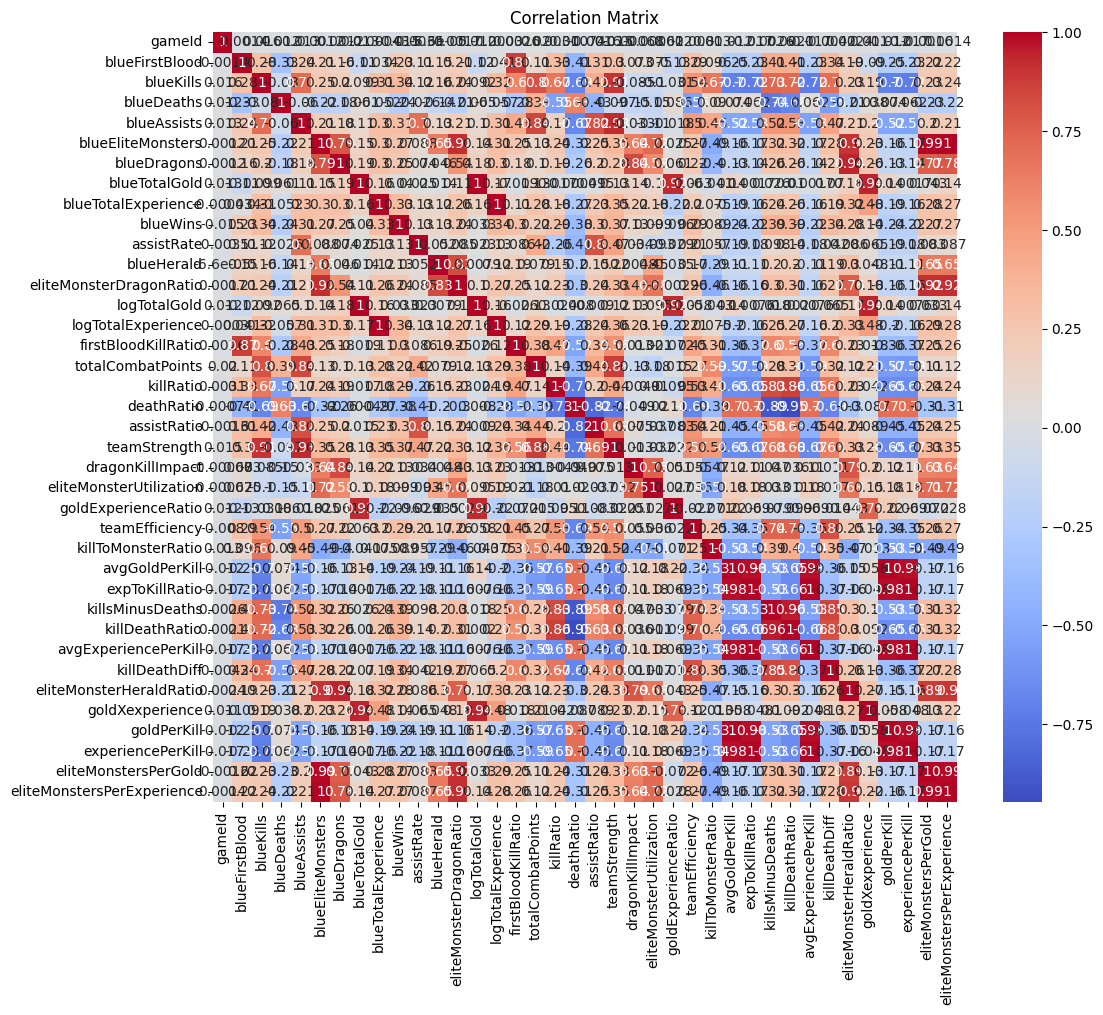

In [5]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- data

In [6]:
# 無限値が含まれているセルをTrueとするブール型データフレームを作成
inf_df = train.replace([np.inf, -np.inf], np.nan).isna()

# 無限値を含む行と列のインデックスを取得
rows_with_inf = inf_df.any(axis=1)
cols_with_inf = inf_df.any(axis=0)

# 無限値を含む行と列のみを選択
inf_rows_cols_df = train.loc[rows_with_inf, cols_with_inf]

# 結果の表示
print(inf_rows_cols_df)

Empty DataFrame
Columns: []
Index: []


In [7]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# test_drop_gameId = test.drop('gameId', axis=1)

test_drop_gameId_temp = test.drop('gameId', axis=1)

# 特徴量の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # 検証データも同じスケーラーを使用して標準化

# テストデータも同じスケーラーを使用して標準化
test_drop_gameId_scaled = scaler.transform(test_drop_gameId_temp)

# NumPy配列からPandasデータフレームに変換
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
test_drop_gameId = pd.DataFrame(test_drop_gameId_scaled, columns=test_drop_gameId_temp.columns)

- 特徴量選択

In [8]:
# # RFECVで特徴量選択を行うためのモデルを定義（ここでは線形モデルの LogisticRegression を使用）
# model = LogisticRegression(random_state=0)

# # RFECVの設定
# # cvはクロスバリデーションの分割数（例: 5分割）
# # scoringはモデル評価の指標
# rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=10)

# # RFECVをトレーニングデータに適用
# rfecv.fit(X_train, y_train)

# # 選択された特徴量の確認
# print("選択された特徴量の数:", rfecv.n_features_)
# selected_features = X_train.columns[rfecv.support_]
# print("選択された特徴量:", selected_features)

# # 選択された特徴量に基づいてデータセットを更新
# X_train = X_train[selected_features]
# X_val = X_val[selected_features]
# test_drop_gameId = test_drop_gameId[selected_features]

- 他model optuna無し

In [9]:
best_params_mlp = {'hidden_layer_sizes': (100,), 'alpha': 0.001}
best_params_svc = {'C': 1.0, 'kernel': 'rbf'}

- optuna_Lgbm

In [10]:
def objective(trial):
    # Optunaで調整するハイパーパラメータ
    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_bin": trial.suggest_int("max_bin", 200, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # クロスバリデーションでのスコア計算
    kf = KFold(n_splits=3, shuffle=True, random_state=71)
    scores = []
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)

        callbacks = [lgb.early_stopping(100)]
        model = lgb.train(param, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)
        preds = model.predict(va_x)
        pred_labels = np.rint(preds)
        score = accuracy_score(va_y, pred_labels)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 最適なパラメータを取得
best_params_lgbm = study.best_params
print("Best params:", best_params_lgbm)

[I 2024-01-27 14:51:03,866] A new study created in memory with name: no-name-c7ca96af-45f6-47bf-8aa2-139cf18391d6


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.465105
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.478218
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:05,343] Trial 0 finished with value: 0.7709361950738262 and parameters: {'num_leaves': 71, 'max_bin': 266, 'learning_rate': 0.06133001505221598, 'bagging_fraction': 0.5069087181462586, 'bagging_freq': 3, 'feature_fraction': 0.5209751584909749, 'min_child_samples': 25}. Best is trial 0 with value: 0.7709361950738262.


Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.473581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.48029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.495132
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:09,986] Trial 1 finished with value: 0.7635947392787621 and parameters: {'num_leaves': 160, 'max_bin': 317, 'learning_rate': 0.034665613619771794, 'bagging_fraction': 0.7235344172026992, 'bagging_freq': 4, 'feature_fraction': 0.8403651651465973, 'min_child_samples': 11}. Best is trial 0 with value: 0.7709361950738262.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.487033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.462774
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.475515
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:10,958] Trial 2 finished with value: 0.7684365366952691 and parameters: {'num_leaves': 220, 'max_bin': 313, 'learning_rate': 0.07977515619701302, 'bagging_fraction': 0.7830764139759794, 'bagging_freq': 1, 'feature_fraction': 0.5328911225895927, 'min_child_samples': 35}. Best is trial 0 with value: 0.7709361950738262.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.474443
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.467838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.47654
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:11,673] Trial 3 finished with value: 0.7676554575288753 and parameters: {'num_leaves': 137, 'max_bin': 219, 'learning_rate': 0.07794401040855976, 'bagging_fraction': 0.8305373535839462, 'bagging_freq': 4, 'feature_fraction': 0.8864403718482696, 'min_child_samples': 60}. Best is trial 0 with value: 0.7709361950738262.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.476972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.463488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.469727
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:12,613] Trial 4 finished with value: 0.7710929821069453 and parameters: {'num_leaves': 152, 'max_bin': 331, 'learning_rate': 0.025054711058833137, 'bagging_fraction': 0.4806534886027853, 'bagging_freq': 6, 'feature_fraction': 0.483497397393817, 'min_child_samples': 58}. Best is trial 4 with value: 0.7710929821069453.


Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.470723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.463688
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:13,152] Trial 5 finished with value: 0.7678108531777679 and parameters: {'num_leaves': 66, 'max_bin': 253, 'learning_rate': 0.05274117055153515, 'bagging_fraction': 0.4736956434940843, 'bagging_freq': 7, 'feature_fraction': 0.8506277553970689, 'min_child_samples': 85}. Best is trial 4 with value: 0.7710929821069453.


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.475402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.470978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.466084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.479156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.476064


[I 2024-01-27 14:51:13,820] Trial 6 finished with value: 0.76890492056441 and parameters: {'num_leaves': 166, 'max_bin': 218, 'learning_rate': 0.09691448123263965, 'bagging_fraction': 0.5535388963885449, 'bagging_freq': 5, 'feature_fraction': 0.7456159518836436, 'min_child_samples': 36}. Best is trial 4 with value: 0.7710929821069453.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.459859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.469994
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:14,437] Trial 7 finished with value: 0.772655140439733 and parameters: {'num_leaves': 22, 'max_bin': 228, 'learning_rate': 0.041805832515418424, 'bagging_fraction': 0.6750715748097762, 'bagging_freq': 7, 'feature_fraction': 0.6660673423855573, 'min_child_samples': 65}. Best is trial 7 with value: 0.772655140439733.


Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.472254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.464002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.474777
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:15,496] Trial 8 finished with value: 0.7685929575746444 and parameters: {'num_leaves': 134, 'max_bin': 306, 'learning_rate': 0.043656876716326905, 'bagging_fraction': 0.6488866473017221, 'bagging_freq': 3, 'feature_fraction': 0.5588932215316287, 'min_child_samples': 38}. Best is trial 7 with value: 0.772655140439733.


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.47409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.460112
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.469919
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:16,068] Trial 9 finished with value: 0.7732800916497466 and parameters: {'num_leaves': 219, 'max_bin': 205, 'learning_rate': 0.0740640404763434, 'bagging_fraction': 0.633059033820718, 'bagging_freq': 4, 'feature_fraction': 0.5072085308186021, 'min_child_samples': 82}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.457512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.465894
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:16,994] Trial 10 finished with value: 0.7690620005205241 and parameters: {'num_leaves': 256, 'max_bin': 391, 'learning_rate': 0.09925223977199812, 'bagging_fraction': 0.6176540005447211, 'bagging_freq': 1, 'feature_fraction': 0.4052041229417581, 'min_child_samples': 97}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.470818
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1242]	valid_0's binary_logloss: 0.455944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's binary_logloss: 0.469293
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:19,259] Trial 11 finished with value: 0.7718740612733392 and parameters: {'num_leaves': 6, 'max_bin': 211, 'learning_rate': 0.011633807432377876, 'bagging_fraction': 0.7006716504494459, 'bagging_freq': 7, 'feature_fraction': 0.6480830438357437, 'min_child_samples': 75}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[1395]	valid_0's binary_logloss: 0.466566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.458367
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:19,711] Trial 12 finished with value: 0.7695296520821772 and parameters: {'num_leaves': 14, 'max_bin': 256, 'learning_rate': 0.0661489602218007, 'bagging_fraction': 0.5820902581356601, 'bagging_freq': 5, 'feature_fraction': 0.6546911441270081, 'min_child_samples': 74}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.470592
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.471544
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.461414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.474443
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:20,602] Trial 13 finished with value: 0.7718740612733392 and parameters: {'num_leaves': 75, 'max_bin': 200, 'learning_rate': 0.07580431832311016, 'bagging_fraction': 0.8992483750351485, 'bagging_freq': 3, 'feature_fraction': 0.6485062231577806, 'min_child_samples': 71}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.471949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.461339
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.469738
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:23,550] Trial 14 finished with value: 0.7721865368783459 and parameters: {'num_leaves': 203, 'max_bin': 239, 'learning_rate': 0.04314160180580195, 'bagging_fraction': 0.7066182394718172, 'bagging_freq': 6, 'feature_fraction': 0.7408075767124219, 'min_child_samples': 93}. Best is trial 9 with value: 0.7732800916497466.


Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.469683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.460235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.469863
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:25,767] Trial 15 finished with value: 0.7746868543336419 and parameters: {'num_leaves': 44, 'max_bin': 287, 'learning_rate': 0.02255821123193371, 'bagging_fraction': 0.7673589648761121, 'bagging_freq': 2, 'feature_fraction': 0.40926030288577697, 'min_child_samples': 50}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.469719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.459691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.470502
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:29,591] Trial 16 finished with value: 0.773124110154864 and parameters: {'num_leaves': 92, 'max_bin': 347, 'learning_rate': 0.017452036982413138, 'bagging_fraction': 0.7914438144347823, 'bagging_freq': 2, 'feature_fraction': 0.40032205428546, 'min_child_samples': 49}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.469728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.460909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.472233
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:30,769] Trial 17 finished with value: 0.7724990124833528 and parameters: {'num_leaves': 104, 'max_bin': 285, 'learning_rate': 0.08658133889185224, 'bagging_fraction': 0.7549101090175174, 'bagging_freq': 2, 'feature_fraction': 0.46174091493970587, 'min_child_samples': 48}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.472408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.463499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.470281
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:31,991] Trial 18 finished with value: 0.7706238659303168 and parameters: {'num_leaves': 207, 'max_bin': 364, 'learning_rate': 0.030049701698687002, 'bagging_fraction': 0.4182328131306798, 'bagging_freq': 2, 'feature_fraction': 0.5871593930648042, 'min_child_samples': 85}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.469828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.465106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.474753
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:33,641] Trial 19 finished with value: 0.7695302379281673 and parameters: {'num_leaves': 44, 'max_bin': 285, 'learning_rate': 0.05389774630855718, 'bagging_fraction': 0.8537515609389623, 'bagging_freq': 5, 'feature_fraction': 0.4765689416464178, 'min_child_samples': 16}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.475589
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.459011
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.467874
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:34,376] Trial 20 finished with value: 0.7735924940240048 and parameters: {'num_leaves': 254, 'max_bin': 283, 'learning_rate': 0.0688756918954101, 'bagging_fraction': 0.6299755023888092, 'bagging_freq': 3, 'feature_fraction': 0.4355674195577305, 'min_child_samples': 82}. Best is trial 15 with value: 0.7746868543336419.


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.471071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.458578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.46725
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:35,501] Trial 21 finished with value: 0.775467567346292 and parameters: {'num_leaves': 256, 'max_bin': 283, 'learning_rate': 0.06614693428269931, 'bagging_fraction': 0.619990771875135, 'bagging_freq': 3, 'feature_fraction': 0.436757938874498, 'min_child_samples': 84}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.471095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.46029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.468152
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:36,554] Trial 22 finished with value: 0.7709362683045748 and parameters: {'num_leaves': 255, 'max_bin': 282, 'learning_rate': 0.06576090392480069, 'bagging_fraction': 0.5799297587381314, 'bagging_freq': 3, 'feature_fraction': 0.44189149313281156, 'min_child_samples': 91}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.469032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.45738
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.466726
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:37,597] Trial 23 finished with value: 0.771873182504354 and parameters: {'num_leaves': 236, 'max_bin': 277, 'learning_rate': 0.05972474039657042, 'bagging_fraction': 0.5955172372066352, 'bagging_freq': 2, 'feature_fraction': 0.43671705851678644, 'min_child_samples': 99}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.467555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.460868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.471335
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:38,689] Trial 24 finished with value: 0.7714051647889569 and parameters: {'num_leaves': 180, 'max_bin': 297, 'learning_rate': 0.08907045610241274, 'bagging_fraction': 0.666079581132234, 'bagging_freq': 1, 'feature_fraction': 0.5898068072681008, 'min_child_samples': 44}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.476288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.461677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.46989
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:39,707] Trial 25 finished with value: 0.7714054577119521 and parameters: {'num_leaves': 184, 'max_bin': 332, 'learning_rate': 0.05214593942897647, 'bagging_fraction': 0.539853500674643, 'bagging_freq': 3, 'feature_fraction': 0.4332637297031099, 'min_child_samples': 56}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.469906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.458936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.467076
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:40,536] Trial 26 finished with value: 0.7698427867639229 and parameters: {'num_leaves': 229, 'max_bin': 245, 'learning_rate': 0.06948764470740537, 'bagging_fraction': 0.7468325472602659, 'bagging_freq': 2, 'feature_fraction': 0.4015817763590827, 'min_child_samples': 69}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.470398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.459578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.46907
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:41,261] Trial 27 finished with value: 0.7735926404855022 and parameters: {'num_leaves': 242, 'max_bin': 269, 'learning_rate': 0.08627851562234293, 'bagging_fraction': 0.6721167027716236, 'bagging_freq': 3, 'feature_fraction': 0.4818187513173886, 'min_child_samples': 81}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.469859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.461488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.471216
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:41,973] Trial 28 finished with value: 0.771248963601828 and parameters: {'num_leaves': 117, 'max_bin': 265, 'learning_rate': 0.08637312680430417, 'bagging_fraction': 0.8111079637730375, 'bagging_freq': 4, 'feature_fraction': 0.49424848338943106, 'min_child_samples': 65}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.469393
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.45972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.467814
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:43,475] Trial 29 finished with value: 0.771404505712218 and parameters: {'num_leaves': 41, 'max_bin': 266, 'learning_rate': 0.058569174211633726, 'bagging_fraction': 0.7518050609000373, 'bagging_freq': 2, 'feature_fraction': 0.5654266185299472, 'min_child_samples': 80}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.469905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.470721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.481349
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:45,293] Trial 30 finished with value: 0.762343811628252 and parameters: {'num_leaves': 194, 'max_bin': 298, 'learning_rate': 0.08261496899150095, 'bagging_fraction': 0.684660743130338, 'bagging_freq': 1, 'feature_fraction': 0.5229138289549584, 'min_child_samples': 18}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.478484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.45682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.468484
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:45,896] Trial 31 finished with value: 0.7714051647889569 and parameters: {'num_leaves': 241, 'max_bin': 294, 'learning_rate': 0.09286713151692899, 'bagging_fraction': 0.6243511816311418, 'bagging_freq': 3, 'feature_fraction': 0.4597200451401324, 'min_child_samples': 90}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.470587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.459071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.469586
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:46,912] Trial 32 finished with value: 0.7735927869469998 and parameters: {'num_leaves': 247, 'max_bin': 272, 'learning_rate': 0.0730608726480635, 'bagging_fraction': 0.7250084349066218, 'bagging_freq': 3, 'feature_fraction': 0.43529750788358634, 'min_child_samples': 77}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.466783
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.46115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.470639
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:47,764] Trial 33 finished with value: 0.7690619272897754 and parameters: {'num_leaves': 217, 'max_bin': 318, 'learning_rate': 0.07221578796758858, 'bagging_fraction': 0.7281038838911112, 'bagging_freq': 4, 'feature_fraction': 0.5471055490845103, 'min_child_samples': 64}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.471487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.468591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.47539
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:49,348] Trial 34 finished with value: 0.7673435677698586 and parameters: {'num_leaves': 236, 'max_bin': 269, 'learning_rate': 0.07927404113924061, 'bagging_fraction': 0.7301308365348425, 'bagging_freq': 3, 'feature_fraction': 0.5182337802296614, 'min_child_samples': 30}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.472698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.461046
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.46704
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:50,262] Trial 35 finished with value: 0.7724993054063479 and parameters: {'num_leaves': 242, 'max_bin': 252, 'learning_rate': 0.06421402594358308, 'bagging_fraction': 0.779805881210688, 'bagging_freq': 2, 'feature_fraction': 0.46899711826796475, 'min_child_samples': 79}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.471519
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.460688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.472001
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:51,451] Trial 36 finished with value: 0.7739054822442529 and parameters: {'num_leaves': 163, 'max_bin': 233, 'learning_rate': 0.08010102235030143, 'bagging_fraction': 0.8387875935427512, 'bagging_freq': 4, 'feature_fraction': 0.425810773167495, 'min_child_samples': 53}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.468732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.463994
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.471365
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:53,566] Trial 37 finished with value: 0.7712492565248231 and parameters: {'num_leaves': 149, 'max_bin': 233, 'learning_rate': 0.03382737508844101, 'bagging_fraction': 0.8469778884427964, 'bagging_freq': 4, 'feature_fraction': 0.4215141874471365, 'min_child_samples': 41}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.471411
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.461906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.470594
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:54,965] Trial 38 finished with value: 0.7721863904168483 and parameters: {'num_leaves': 168, 'max_bin': 317, 'learning_rate': 0.022370799921483425, 'bagging_fraction': 0.8771274622177746, 'bagging_freq': 4, 'feature_fraction': 0.44794583030905066, 'min_child_samples': 55}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.471327
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.468406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.483849
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:56,755] Trial 39 finished with value: 0.768906165487139 and parameters: {'num_leaves': 120, 'max_bin': 224, 'learning_rate': 0.04767340536753107, 'bagging_fraction': 0.8262096713265386, 'bagging_freq': 5, 'feature_fraction': 0.7949757862501641, 'min_child_samples': 29}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.481668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.467433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.479528
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:57,803] Trial 40 finished with value: 0.7729681286599813 and parameters: {'num_leaves': 55, 'max_bin': 256, 'learning_rate': 0.0796095564156063, 'bagging_fraction': 0.7825424179196508, 'bagging_freq': 4, 'feature_fraction': 0.5064571986244311, 'min_child_samples': 7}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.473642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.460045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.470185
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:58,808] Trial 41 finished with value: 0.7693737438180434 and parameters: {'num_leaves': 224, 'max_bin': 273, 'learning_rate': 0.08186161399716901, 'bagging_fraction': 0.6553344514839069, 'bagging_freq': 3, 'feature_fraction': 0.4872385837522919, 'min_child_samples': 60}. Best is trial 21 with value: 0.775467567346292.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.472977
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.460464
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.464528
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:51:59,633] Trial 42 finished with value: 0.7757796035668062 and parameters: {'num_leaves': 207, 'max_bin': 307, 'learning_rate': 0.09284575284382743, 'bagging_fraction': 0.716621511291988, 'bagging_freq': 3, 'feature_fraction': 0.41795044799435926, 'min_child_samples': 75}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.468703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.463276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.470893
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:00,905] Trial 43 finished with value: 0.7718741345040879 and parameters: {'num_leaves': 206, 'max_bin': 306, 'learning_rate': 0.09297465926774168, 'bagging_fraction': 0.8021425578391772, 'bagging_freq': 3, 'feature_fraction': 0.41379276827838896, 'min_child_samples': 50}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.4739
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.459595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.469277
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:01,436] Trial 44 finished with value: 0.7731241833856127 and parameters: {'num_leaves': 155, 'max_bin': 309, 'learning_rate': 0.09275970965943954, 'bagging_fraction': 0.6943494383165598, 'bagging_freq': 4, 'feature_fraction': 0.4277613342391621, 'min_child_samples': 89}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.467074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.461419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.470866
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:02,183] Trial 45 finished with value: 0.7690609752900412 and parameters: {'num_leaves': 173, 'max_bin': 326, 'learning_rate': 0.07410900964198633, 'bagging_fraction': 0.7132900394206022, 'bagging_freq': 2, 'feature_fraction': 0.4532696259613154, 'min_child_samples': 74}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.460771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.469936
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:03,666] Trial 46 finished with value: 0.7735924940240048 and parameters: {'num_leaves': 189, 'max_bin': 346, 'learning_rate': 0.09933679941303658, 'bagging_fraction': 0.7677105458675593, 'bagging_freq': 5, 'feature_fraction': 0.41976774907303227, 'min_child_samples': 68}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.468139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.463157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.472053
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:04,643] Trial 47 finished with value: 0.7692171764771704 and parameters: {'num_leaves': 215, 'max_bin': 291, 'learning_rate': 0.0628966668153356, 'bagging_fraction': 0.8266673726461559, 'bagging_freq': 3, 'feature_fraction': 0.6951333407199136, 'min_child_samples': 62}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.470478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.46024
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.470862
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:05,460] Trial 48 finished with value: 0.7681238413980159 and parameters: {'num_leaves': 142, 'max_bin': 244, 'learning_rate': 0.07583716574767993, 'bagging_fraction': 0.5111934915882463, 'bagging_freq': 1, 'feature_fraction': 0.621283621806115, 'min_child_samples': 77}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.473186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.462774
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.471338
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:06,403] Trial 49 finished with value: 0.7746864149491492 and parameters: {'num_leaves': 197, 'max_bin': 216, 'learning_rate': 0.07101776889715819, 'bagging_fraction': 0.7219128122310501, 'bagging_freq': 6, 'feature_fraction': 0.46300247948861656, 'min_child_samples': 53}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.474382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.465067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.47752
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:07,760] Trial 50 finished with value: 0.7704678112046853 and parameters: {'num_leaves': 193, 'max_bin': 213, 'learning_rate': 0.056490317347668566, 'bagging_fraction': 0.8891992748435857, 'bagging_freq': 6, 'feature_fraction': 0.543010791923668, 'min_child_samples': 45}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.474089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.462163
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.472034
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:08,745] Trial 51 finished with value: 0.7723428845269726 and parameters: {'num_leaves': 199, 'max_bin': 233, 'learning_rate': 0.07047227746530618, 'bagging_fraction': 0.7252918822842339, 'bagging_freq': 6, 'feature_fraction': 0.4016106258138727, 'min_child_samples': 54}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.471246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.461261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.468014
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.471343


[I 2024-01-27 14:52:09,563] Trial 52 finished with value: 0.7742183240030037 and parameters: {'num_leaves': 177, 'max_bin': 221, 'learning_rate': 0.06774360118664845, 'bagging_fraction': 0.7459142258980527, 'bagging_freq': 5, 'feature_fraction': 0.46189818957139367, 'min_child_samples': 86}. Best is trial 42 with value: 0.7757796035668062.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.458738
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.467309
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:10,384] Trial 53 finished with value: 0.7743739393441423 and parameters: {'num_leaves': 162, 'max_bin': 219, 'learning_rate': 0.0610174651112902, 'bagging_fraction': 0.766133351003358, 'bagging_freq': 6, 'feature_fraction': 0.46541671470653695, 'min_child_samples': 95}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.468229
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.459224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.468078
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:12,829] Trial 54 finished with value: 0.771873475427349 and parameters: {'num_leaves': 176, 'max_bin': 205, 'learning_rate': 0.04845524618789742, 'bagging_fraction': 0.7643093954332307, 'bagging_freq': 6, 'feature_fraction': 0.4619687424233386, 'min_child_samples': 96}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.468409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.460452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.470342


[I 2024-01-27 14:52:13,463] Trial 55 finished with value: 0.7721859510323559 and parameters: {'num_leaves': 141, 'max_bin': 224, 'learning_rate': 0.0613911337104597, 'bagging_fraction': 0.6979257749705294, 'bagging_freq': 7, 'feature_fraction': 0.5066806594956286, 'min_child_samples': 87}. Best is trial 42 with value: 0.7757796035668062.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.468687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's binary_logloss: 0.458391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.468617
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:15,594] Trial 56 finished with value: 0.7712488171403304 and parameters: {'num_leaves': 128, 'max_bin': 215, 'learning_rate': 0.010948360163109488, 'bagging_fraction': 0.7434283219399599, 'bagging_freq': 6, 'feature_fraction': 0.4751510739261323, 'min_child_samples': 93}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[491]	valid_0's binary_logloss: 0.467267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.46272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.469311
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:16,644] Trial 57 finished with value: 0.7696861461923014 and parameters: {'num_leaves': 210, 'max_bin': 380, 'learning_rate': 0.05169098851897172, 'bagging_fraction': 0.7999136080932422, 'bagging_freq': 5, 'feature_fraction': 0.8623094408873417, 'min_child_samples': 94}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.473549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.45916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469796
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:17,263] Trial 58 finished with value: 0.7742175184647672 and parameters: {'num_leaves': 79, 'max_bin': 220, 'learning_rate': 0.06846973860998053, 'bagging_fraction': 0.6424100314310506, 'bagging_freq': 7, 'feature_fraction': 0.45079719102376126, 'min_child_samples': 100}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.469679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.459767
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.471476
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:18,408] Trial 59 finished with value: 0.7714047986352132 and parameters: {'num_leaves': 156, 'max_bin': 205, 'learning_rate': 0.04006055760632072, 'bagging_fraction': 0.7091304435471353, 'bagging_freq': 6, 'feature_fraction': 0.5039620712789004, 'min_child_samples': 85}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.469003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.458559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.471066


[I 2024-01-27 14:52:19,363] Trial 60 finished with value: 0.7715615856683323 and parameters: {'num_leaves': 186, 'max_bin': 341, 'learning_rate': 0.05526717742935681, 'bagging_fraction': 0.5962434325556736, 'bagging_freq': 5, 'feature_fraction': 0.5260039742443192, 'min_child_samples': 85}. Best is trial 42 with value: 0.7757796035668062.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.470752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.456565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.469398
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:20,174] Trial 61 finished with value: 0.7732805310342394 and parameters: {'num_leaves': 88, 'max_bin': 219, 'learning_rate': 0.06723419570215085, 'bagging_fraction': 0.6447953232382908, 'bagging_freq': 7, 'feature_fraction': 0.4505177817323795, 'min_child_samples': 99}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.467546
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.4594
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.468538
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:21,141] Trial 62 finished with value: 0.7732808239572345 and parameters: {'num_leaves': 68, 'max_bin': 200, 'learning_rate': 0.05938985868185693, 'bagging_fraction': 0.6811310182207976, 'bagging_freq': 7, 'feature_fraction': 0.4844216414488371, 'min_child_samples': 97}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.46741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.458499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.471212
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:21,830] Trial 63 finished with value: 0.7714055309427009 and parameters: {'num_leaves': 77, 'max_bin': 242, 'learning_rate': 0.06682224017000626, 'bagging_fraction': 0.6047523920094933, 'bagging_freq': 6, 'feature_fraction': 0.4462432747663721, 'min_child_samples': 88}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.468251
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.459332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.469152
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:22,831] Trial 64 finished with value: 0.7724991589448503 and parameters: {'num_leaves': 28, 'max_bin': 225, 'learning_rate': 0.0634683432117583, 'bagging_fraction': 0.6491868898036791, 'bagging_freq': 7, 'feature_fraction': 0.42129862791396133, 'min_child_samples': 92}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.468374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.459694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.470841
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.467059


[I 2024-01-27 14:52:23,544] Trial 65 finished with value: 0.7723426648347264 and parameters: {'num_leaves': 33, 'max_bin': 209, 'learning_rate': 0.07037048429510054, 'bagging_fraction': 0.7725789530904055, 'bagging_freq': 7, 'feature_fraction': 0.46864544659689394, 'min_child_samples': 100}. Best is trial 42 with value: 0.7757796035668062.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	valid_0's binary_logloss: 0.455812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.466683
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:25,642] Trial 66 finished with value: 0.771404871865962 and parameters: {'num_leaves': 15, 'max_bin': 251, 'learning_rate': 0.017531900073787035, 'bagging_fraction': 0.7423222981964327, 'bagging_freq': 6, 'feature_fraction': 0.4930629657475323, 'min_child_samples': 72}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.466471
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.465306
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.473222
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:26,913] Trial 67 finished with value: 0.7720301159989708 and parameters: {'num_leaves': 102, 'max_bin': 303, 'learning_rate': 0.07639123342531069, 'bagging_fraction': 0.6170955157067999, 'bagging_freq': 5, 'feature_fraction': 0.41237951175146165, 'min_child_samples': 36}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.476167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.459141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470476
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:27,827] Trial 68 finished with value: 0.7718742809655855 and parameters: {'num_leaves': 59, 'max_bin': 260, 'learning_rate': 0.057613023739644095, 'bagging_fraction': 0.6878588975608132, 'bagging_freq': 5, 'feature_fraction': 0.5750933142031096, 'min_child_samples': 83}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.472778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.457228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.468886
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:28,830] Trial 69 finished with value: 0.7731239636933664 and parameters: {'num_leaves': 169, 'max_bin': 238, 'learning_rate': 0.06163831301291077, 'bagging_fraction': 0.66679707113401, 'bagging_freq': 7, 'feature_fraction': 0.4411121407752309, 'min_child_samples': 96}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.469373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1253]	valid_0's binary_logloss: 0.467239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1751]	valid_0's binary_logloss: 0.470661
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:30,369] Trial 70 finished with value: 0.7678115122545067 and parameters: {'num_leaves': 2, 'max_bin': 219, 'learning_rate': 0.03984527138792495, 'bagging_fraction': 0.5707997747578177, 'bagging_freq': 6, 'feature_fraction': 0.46616927859388735, 'min_child_samples': 91}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[1215]	valid_0's binary_logloss: 0.477007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.463771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.473237
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:31,288] Trial 71 finished with value: 0.7732800916497468 and parameters: {'num_leaves': 165, 'max_bin': 229, 'learning_rate': 0.08358754019753363, 'bagging_fraction': 0.8527027989124594, 'bagging_freq': 4, 'feature_fraction': 0.4314444786638285, 'min_child_samples': 51}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.472853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.459564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.473005
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:32,247] Trial 72 finished with value: 0.7743740858056402 and parameters: {'num_leaves': 162, 'max_bin': 232, 'learning_rate': 0.06795361847024467, 'bagging_fraction': 0.7622137264034482, 'bagging_freq': 5, 'feature_fraction': 0.40007492589261723, 'min_child_samples': 46}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.469019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.461085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.472236
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:33,831] Trial 73 finished with value: 0.7735926404855022 and parameters: {'num_leaves': 178, 'max_bin': 211, 'learning_rate': 0.06649542622455942, 'bagging_fraction': 0.7579905137413627, 'bagging_freq': 5, 'feature_fraction': 0.4104084071308408, 'min_child_samples': 46}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.470047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.460982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.472581
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:35,034] Trial 74 finished with value: 0.7737492078263752 and parameters: {'num_leaves': 147, 'max_bin': 288, 'learning_rate': 0.07273004114128644, 'bagging_fraction': 0.7395393971269214, 'bagging_freq': 5, 'feature_fraction': 0.4008211856757716, 'min_child_samples': 39}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.471491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.461127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.47052
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:36,033] Trial 75 finished with value: 0.7749989637849048 and parameters: {'num_leaves': 226, 'max_bin': 218, 'learning_rate': 0.06887039333801173, 'bagging_fraction': 0.7890199885830128, 'bagging_freq': 6, 'feature_fraction': 0.4525732563859287, 'min_child_samples': 57}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.472726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.459853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.475066
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:37,282] Trial 76 finished with value: 0.7721863904168486 and parameters: {'num_leaves': 226, 'max_bin': 280, 'learning_rate': 0.06549346503483561, 'bagging_fraction': 0.8169848982016457, 'bagging_freq': 6, 'feature_fraction': 0.4317484971742551, 'min_child_samples': 48}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.474368
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.461284
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.468867
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:38,976] Trial 77 finished with value: 0.7726556530549745 and parameters: {'num_leaves': 196, 'max_bin': 325, 'learning_rate': 0.027861501361255453, 'bagging_fraction': 0.7785614990811898, 'bagging_freq': 2, 'feature_fraction': 0.4763055797487028, 'min_child_samples': 58}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.468473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.462062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.474075
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:40,327] Trial 78 finished with value: 0.7734369519136147 and parameters: {'num_leaves': 232, 'max_bin': 313, 'learning_rate': 0.07072416277338618, 'bagging_fraction': 0.792770282219959, 'bagging_freq': 6, 'feature_fraction': 0.45743109621383926, 'min_child_samples': 41}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.474302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.462637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.474767
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:41,386] Trial 79 finished with value: 0.7734362928368758 and parameters: {'num_leaves': 249, 'max_bin': 237, 'learning_rate': 0.060590973896932264, 'bagging_fraction': 0.7145122907865578, 'bagging_freq': 6, 'feature_fraction': 0.7376386078625684, 'min_child_samples': 58}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.473893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.465164
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.47403
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:42,526] Trial 80 finished with value: 0.7721860974938534 and parameters: {'num_leaves': 211, 'max_bin': 209, 'learning_rate': 0.07734942320298571, 'bagging_fraction': 0.8111663545458998, 'bagging_freq': 5, 'feature_fraction': 0.41686191747980317, 'min_child_samples': 33}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.477698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.460665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.468991
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:43,355] Trial 81 finished with value: 0.7732795790345053 and parameters: {'num_leaves': 200, 'max_bin': 218, 'learning_rate': 0.06915351136147276, 'bagging_fraction': 0.7575336958310741, 'bagging_freq': 6, 'feature_fraction': 0.4443588110013903, 'min_child_samples': 67}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.471977
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.460875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.471699
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:44,736] Trial 82 finished with value: 0.7721863171860996 and parameters: {'num_leaves': 45, 'max_bin': 225, 'learning_rate': 0.06425616641774518, 'bagging_fraction': 0.41895469554905745, 'bagging_freq': 7, 'feature_fraction': 0.497409116008282, 'min_child_samples': 44}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.473833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.459587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.46669
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:45,401] Trial 83 finished with value: 0.7723428845269726 and parameters: {'num_leaves': 221, 'max_bin': 248, 'learning_rate': 0.06840888153829495, 'bagging_fraction': 0.788804443989416, 'bagging_freq': 1, 'feature_fraction': 0.4531836366777865, 'min_child_samples': 94}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.46725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.461801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.471787
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:46,181] Trial 84 finished with value: 0.7739054090135041 and parameters: {'num_leaves': 183, 'max_bin': 230, 'learning_rate': 0.07389569426322905, 'bagging_fraction': 0.7303450304181044, 'bagging_freq': 4, 'feature_fraction': 0.43652769416502635, 'min_child_samples': 52}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.471834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.458295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.468655
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:47,157] Trial 85 finished with value: 0.7679677134416357 and parameters: {'num_leaves': 161, 'max_bin': 216, 'learning_rate': 0.0541393738842802, 'bagging_fraction': 0.6351313012112082, 'bagging_freq': 2, 'feature_fraction': 0.5154715793519469, 'min_child_samples': 78}. Best is trial 42 with value: 0.7757796035668062.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.472809
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.461257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.468911
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:47,870] Trial 86 finished with value: 0.7768746961839309 and parameters: {'num_leaves': 191, 'max_bin': 222, 'learning_rate': 0.08952133649566185, 'bagging_fraction': 0.7575349544703198, 'bagging_freq': 5, 'feature_fraction': 0.4166282055353523, 'min_child_samples': 82}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.468067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.461837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.469746
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:48,794] Trial 87 finished with value: 0.7745303602235177 and parameters: {'num_leaves': 190, 'max_bin': 204, 'learning_rate': 0.09611131748114235, 'bagging_fraction': 0.7697806712625961, 'bagging_freq': 5, 'feature_fraction': 0.4133459169310729, 'min_child_samples': 83}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.470022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.46039
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:49,478] Trial 88 finished with value: 0.774061976354377 and parameters: {'num_leaves': 203, 'max_bin': 204, 'learning_rate': 0.0946848478206668, 'bagging_fraction': 0.7707929712233496, 'bagging_freq': 5, 'feature_fraction': 0.40786220534668055, 'min_child_samples': 82}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.467917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.469198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.460436
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.470956
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:50,214] Trial 89 finished with value: 0.7723428112962237 and parameters: {'num_leaves': 191, 'max_bin': 299, 'learning_rate': 0.09064197065913948, 'bagging_fraction': 0.8033524265760652, 'bagging_freq': 6, 'feature_fraction': 0.42426654474472714, 'min_child_samples': 74}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.469416
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.462987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.467368
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:50,909] Trial 90 finished with value: 0.7710932017991916 and parameters: {'num_leaves': 217, 'max_bin': 201, 'learning_rate': 0.0952881986195106, 'bagging_fraction': 0.761001913513637, 'bagging_freq': 3, 'feature_fraction': 0.41665411224628274, 'min_child_samples': 71}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.469743
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.460197
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.468463


[I 2024-01-27 14:52:51,476] Trial 91 finished with value: 0.774998963784905 and parameters: {'num_leaves': 174, 'max_bin': 211, 'learning_rate': 0.09668913888415165, 'bagging_fraction': 0.7487112451849066, 'bagging_freq': 5, 'feature_fraction': 0.40079192342224956, 'min_child_samples': 87}. Best is trial 86 with value: 0.7768746961839309.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.466551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.46084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.4693
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:52,142] Trial 92 finished with value: 0.7731241833856127 and parameters: {'num_leaves': 171, 'max_bin': 211, 'learning_rate': 0.09748095411162462, 'bagging_fraction': 0.7346362737727395, 'bagging_freq': 5, 'feature_fraction': 0.40326720843679037, 'min_child_samples': 81}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.470609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.459691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.469486
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:52,927] Trial 93 finished with value: 0.7714053112504545 and parameters: {'num_leaves': 182, 'max_bin': 207, 'learning_rate': 0.0887944140391416, 'bagging_fraction': 0.7851705498834128, 'bagging_freq': 4, 'feature_fraction': 0.4359788562175551, 'min_child_samples': 89}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.467719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.460541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.4683


[I 2024-01-27 14:52:53,550] Trial 94 finished with value: 0.7740618298928794 and parameters: {'num_leaves': 206, 'max_bin': 214, 'learning_rate': 0.09743969684639041, 'bagging_fraction': 0.7485318847973051, 'bagging_freq': 5, 'feature_fraction': 0.4241950483138397, 'min_child_samples': 83}. Best is trial 86 with value: 0.7768746961839309.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.469347
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.46036
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.468426
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:54,886] Trial 95 finished with value: 0.7737488416726314 and parameters: {'num_leaves': 191, 'max_bin': 229, 'learning_rate': 0.08471702732167667, 'bagging_fraction': 0.7131865689399893, 'bagging_freq': 5, 'feature_fraction': 0.4006617219051617, 'min_child_samples': 79}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.460432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.471691
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:55,691] Trial 96 finished with value: 0.7740619031236283 and parameters: {'num_leaves': 132, 'max_bin': 358, 'learning_rate': 0.08802223304708301, 'bagging_fraction': 0.7734349480225401, 'bagging_freq': 6, 'feature_fraction': 0.6146478046775585, 'min_child_samples': 76}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.471663
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.460757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.472782
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:56,793] Trial 97 finished with value: 0.7692172497079192 and parameters: {'num_leaves': 236, 'max_bin': 276, 'learning_rate': 0.09162507044832892, 'bagging_fraction': 0.7212508802968887, 'bagging_freq': 4, 'feature_fraction': 0.41306696905346824, 'min_child_samples': 56}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.469082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.460466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.470036
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:57,622] Trial 98 finished with value: 0.7718740612733391 and parameters: {'num_leaves': 197, 'max_bin': 290, 'learning_rate': 0.09982903919711852, 'bagging_fraction': 0.7951321260288331, 'bagging_freq': 2, 'feature_fraction': 0.4415785761659515, 'min_child_samples': 61}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.471972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.461377
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.474128
Training until validation scores don't improve for 100 rounds


[I 2024-01-27 14:52:58,639] Trial 99 finished with value: 0.7731234510781251 and parameters: {'num_leaves': 153, 'max_bin': 234, 'learning_rate': 0.09513439595022549, 'bagging_fraction': 0.8350650327641427, 'bagging_freq': 5, 'feature_fraction': 0.42883995198870284, 'min_child_samples': 50}. Best is trial 86 with value: 0.7768746961839309.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.470611
Best params: {'num_leaves': 191, 'max_bin': 222, 'learning_rate': 0.08952133649566185, 'bagging_fraction': 0.7575349544703198, 'bagging_freq': 5, 'feature_fraction': 0.4166282055353523, 'min_child_samples': 82}


- optuna_rf

In [11]:
def objective_random_forest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60)
    }

    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_random_forest, n_trials=100)
best_params_rf = study_rf.best_params

[I 2024-01-27 14:52:58,651] A new study created in memory with name: no-name-53d95cb5-957e-4ee0-b521-3e97be49a5d5
[I 2024-01-27 14:53:00,742] Trial 0 finished with value: 0.7720307018449608 and parameters: {'n_estimators': 229, 'max_depth': 26, 'min_samples_split': 29, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.7720307018449608.
[I 2024-01-27 14:53:01,465] Trial 1 finished with value: 0.7528123170604357 and parameters: {'n_estimators': 86, 'max_depth': 2, 'min_samples_split': 66, 'min_samples_leaf': 49}. Best is trial 0 with value: 0.7720307018449608.
[I 2024-01-27 14:53:02,814] Trial 2 finished with value: 0.7685935434206347 and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 128, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7720307018449608.
[I 2024-01-27 14:53:03,819] Trial 3 finished with value: 0.7617190801104847 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 40}. Best is trial 0 with 

- optuna_SVM

In [12]:
# 1時間でも終わらないので飛ばす


# def objective_svm(trial):
#     params = {
#         "C": trial.suggest_float("C", 0.1, 10.0),
#         "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
#         "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
#     }

#     clf = svm.SVC(**params)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

# study_svm = optuna.create_study(direction="maximize")
# study_svm.optimize(objective_svm, n_trials=100)
# best_params_svm = study_svm.best_params

- optuna_LR

In [13]:
def objective_logistic_regression(trial):
    params = {
        "C": trial.suggest_loguniform("C", 1e-4, 10.0),
        "penalty": trial.suggest_categorical("penalty", ["l2", "none"])
    }

    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_logistic_regression, n_trials=100)
best_params_lr = study_lr.best_params

[I 2024-01-27 14:54:30,355] A new study created in memory with name: no-name-5b3826f3-eb0e-4953-89d8-51d0c932bb1a
/tmp/ipykernel_13946/3235143177.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-4, 10.0),
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behavi

- optuna_catboost

In [14]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"])
    }

    clf = CatBoostClassifier(**params, verbose=0)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=100)
best_params_cb = study_cb.best_params

[I 2024-01-27 14:54:44,322] A new study created in memory with name: no-name-2d152b69-86b9-4678-82f4-b31d58fec103
[I 2024-01-27 14:54:45,991] Trial 0 finished with value: 0.7632792612130556 and parameters: {'iterations': 236, 'depth': 8, 'learning_rate': 0.11370607424033101, 'random_strength': 66, 'bagging_temperature': 0.0681477437568283, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.7632792612130556.
[I 2024-01-27 14:54:46,793] Trial 1 finished with value: 0.7428128047772226 and parameters: {'iterations': 137, 'depth': 6, 'learning_rate': 0.014130001720255574, 'random_strength': 41, 'bagging_temperature': 0.6674308216902441, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.7632792612130556.
[I 2024-01-27 14:54:47,949] Trial 2 finished with value: 0.7765617079636828 and parameters: {'iterations': 283, 'depth': 4, 'learning_rate': 0.08092642175381795, 'random_strength': 65, 'bagging_temperature': 0.8455810902856813, 'od_type': 'Iter'}. Best is trial 2 with value: 0.7765617

- optuna_XGBoost

In [15]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgboost, n_trials=100)
best_params_xgb = study_xgb.best_params

[I 2024-01-27 14:56:42,501] A new study created in memory with name: no-name-fa31c64a-5070-49f6-82ec-53c3e22d6587
[I 2024-01-27 14:56:44,322] Trial 0 finished with value: 0.7612477670113931 and parameters: {'n_estimators': 237, 'max_depth': 21, 'learning_rate': 0.019172587380647442, 'subsample': 0.6798033980272593, 'colsample_bytree': 0.7095896008645411, 'gamma': 0.48508817809609983}. Best is trial 0 with value: 0.7612477670113931.
[I 2024-01-27 14:56:45,014] Trial 1 finished with value: 0.7582790656869564 and parameters: {'n_estimators': 234, 'max_depth': 16, 'learning_rate': 0.1482623778742986, 'subsample': 0.7741546590330166, 'colsample_bytree': 0.8223324315639482, 'gamma': 0.9455586462270407}. Best is trial 0 with value: 0.7612477670113931.
[I 2024-01-27 14:56:45,535] Trial 2 finished with value: 0.7756233291489284 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.026222528888913778, 'subsample': 0.8996910912705334, 'colsample_bytree': 0.519030959997276, 'gam

- study

In [16]:
def predict(X_train, y_train, X_test, mode, X_val):
    preds = []  # バリデーションデータに対する予測結果を格納するリスト
    preds_val = []
    preds_test = []  # テストデータに対する予測結果を格納するリスト

    # クロスバリデーションで予測を実行
    kf = KFold(n_splits=3, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # モデルを構築
        if mode == 'LightGBM':
            lgb_train = lgb.Dataset(tr_x, tr_y)
            lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)
            # 早期停止コールバックを設定
            callbacks = [lgb.early_stopping(100)]
            model = lgb.train(best_params_lgbm, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)

        elif mode == 'RandomForest':
            model = RandomForestClassifier(random_state=123, **best_params_rf)
            model = model.fit(tr_x, tr_y)

        elif mode == 'SVM':
            model = SVC(**best_params_svc)
            model = model.fit(tr_x, tr_y)

        elif mode == 'LogisticRegression':
            model = LogisticRegression(**best_params_lr)
            model = model.fit(tr_x, tr_y)

        elif mode == 'CatBoost':
            model = CatBoostClassifier(**best_params_cb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'XGBoost':
            model = xgb.XGBClassifier(**best_params_xgb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'MLP':
            model = MLPClassifier(**best_params_mlp)
            model = model.fit(tr_x, tr_y)
            

        

        # バリデーションデータに対する予測
        pred = model.predict(va_x)
        preds.append(pred)

        pred_val = model.predict(X_val)
        preds_val.append(pred_val)

        # テストデータに対する予測
        pred_test = model.predict(X_test)
        preds_test.append(pred_test)

    # バリデーションデータに対する予測結果を連結、元の順序に戻す
    preds = np.concatenate(preds, axis=0)

    # valに対する平均予測値を取得
    preds_val = np.mean(preds_val, axis=0)

    # テストデータに対する平均予測値を取得
    preds_test = np.mean(preds_test, axis=0)

    return preds, preds_val, preds_test

- base model

In [17]:
# 異なるモデルのベースモデルを定義
base_models = [
    ('LightGBM', lgb.LGBMClassifier(**best_params_lgbm)),
    ('RandomForest', RandomForestClassifier(random_state=123, **best_params_rf)),
    ('LogisticRegression', LogisticRegression(**best_params_lr)),
    ('XGBoost', XGBClassifier(**best_params_xgb)),
    ('CatBoost', CatBoostClassifier(**best_params_cb)),
    ('MLP', MLPClassifier(**best_params_mlp)),
    # ('SVM', SVC(**best_params_svc))
]

- base調査【各1個ずつ除外】

In [18]:
# 各ベースモデルを一つずつ除外してパフォーマンスを評価

accuracy_check = []
model_name_check = []

for name, model in base_models:
    # 現在のモデルを除外
    current_models = [m for m in base_models if m[0] != name]

    # 新しいスタッキングモデル
    stacking_model = StackingClassifier(estimators=current_models, final_estimator=CatBoostClassifier(**best_params_cb))
    stacking_model.fit(X_train, y_train)
    predictions = stacking_model.predict(X_val)
    accuracy_check.append(accuracy_score(y_val, predictions))
    model_name_check.append(name)

for i in range(len(model_name_check)):
    print(f"{model_name_check[i]}を除外した時の精度: {accuracy_check[i]}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6601350	total: 47.6ms	remaining: 12.4s
1:	learn: 0.6496841	total: 48.7ms	remaining: 6.31s
2:	learn: 0.6355231	total: 50ms	remaining: 4.3s
3:	learn: 0.6302170	total: 51.2ms	remaining: 3.29s
4:	learn: 0.6196106	total: 52.3ms	remaining: 2.68s
5:	learn: 0.6095522	total: 53.5ms	remaining: 2.27s
6:	learn: 0.6087223	total: 54.7ms	remaining: 1.99s
7:	learn: 0.6047065	total: 55.9ms	remaining: 1.77s
8:	learn: 0.5989139	total: 57ms	remaining: 1.59s
9:	learn: 0.5917532	total: 58.3ms	remaining: 1.46s
10:	learn: 0.5869990	total: 59.6ms	remaining: 1.35s
11:	learn: 0.5847438	total: 60.8ms	remaining: 1.26s
12:	learn: 0.5831664	total: 62.2ms	remaining: 1.19s
13:	learn: 0.5800828	total: 63.5ms	remaining: 1.12s
14:	learn: 0.5747414	total: 64.7ms	remaining: 1.06s
15:	learn: 0.5739812	total: 65.8ms	remaining: 1.01s
16:	learn: 0.5641392	total: 67.2ms	remaining: 964ms
17:	learn: 0.5608006	total: 68.7ms	remaining: 927ms
18:	learn: 0.5601359	total: 70.7ms	remaining: 901ms
19:	learn: 0.5586463	total:

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

0:	learn: 0.6787396	total: 1.1ms	remaining: 286ms
1:	learn: 0.6647734	total: 2.17ms	remaining: 282ms
2:	learn: 0.6571787	total: 3.21ms	remaining: 276ms
3:	learn: 0.6428572	total: 4.31ms	remaining: 277ms
4:	learn: 0.6351658	total: 5.61ms	remaining: 287ms
5:	learn: 0.6318587	total: 6.74ms	remaining: 286ms
6:	learn: 0.6226522	total: 7.76ms	remaining: 281ms
7:	learn: 0.6123552	total: 8.99ms	remaining: 284ms
8:	learn: 0.5915091	total: 10.2ms	remaining: 285ms
9:	learn: 0.5841820	total: 11.2ms	remaining: 282ms
10:	learn: 0.5793981	total: 12.3ms	remaining: 279ms
11:	learn: 0.5687619	total: 13.2ms	remaining: 275ms
12:	learn: 0.5655948	total: 14.4ms	remaining: 274ms
13:	learn: 0.5640122	total: 15.5ms	remaining: 273ms
14:	learn: 0.5562583	total: 16.6ms	remaining: 272ms
15:	learn: 0.5550373	total: 18.2ms	remaining: 279ms
16:	learn: 0.5539971	total: 19.2ms	remaining: 276ms
17:	learn: 0.5528697	total: 20.3ms	remaining: 274ms
18:	learn: 0.5510462	total: 21.4ms	remaining: 272ms
19:	learn: 0.5496932	to

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6528671	total: 12.1ms	remaining: 3.15s
1:	learn: 0.6182010	total: 14.9ms	remaining: 1.93s
2:	learn: 0.5932346	total: 29.4ms	remaining: 2.53s
3:	learn: 0.5651722	total: 32.5ms	remaining: 2.08s
4:	learn: 0.5437814	total: 41.5ms	remaining: 2.12s
5:	learn: 0.5285661	total: 43.2ms	remaining: 1.84s
6:	learn: 0.5156217	total: 44.9ms	remaining: 1.63s
7:	learn: 0.5094562	total: 46.8ms	remaining: 1.48s
8:	learn: 0.5006458	total: 48.4ms	remaining: 1.35s
9:	learn: 0.4938699	total: 50.1ms	remaining: 1.26s
10:	learn: 0.4889496	total: 51.7ms	remaining: 1.18s
11:	learn: 0.4852641	total: 53.3ms	remaining: 1.11s
12:	learn: 0.4813587	total: 55.5ms	remaining: 1.06s
13:	learn: 0.4787341	total: 57ms	remaining: 1s
14:	learn: 0.4757950	total: 58.7ms	remaining: 963ms
15:	learn: 0.4743451	total: 60.3ms	remaining: 923ms
16:	learn: 0.4720702	total: 61.9ms	remaining: 888ms
17:	learn: 0.4702425	total: 63.7ms	remaining: 860ms
18:	learn: 0.4696860	total: 65.2ms	remaining: 830ms
19:	learn: 0.4685438	total:

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6601350	total: 1.38ms	remaining: 360ms
1:	learn: 0.6496841	total: 2.67ms	remaining: 346ms
2:	learn: 0.6355231	total: 4.15ms	remaining: 357ms
3:	learn: 0.6302170	total: 5.43ms	remaining: 349ms
4:	learn: 0.6196106	total: 6.66ms	remaining: 341ms
5:	learn: 0.6095522	total: 8.12ms	remaining: 345ms
6:	learn: 0.6087223	total: 9.32ms	remaining: 338ms
7:	learn: 0.6047065	total: 10.7ms	remaining: 339ms
8:	learn: 0.5989139	total: 12.3ms	remaining: 343ms
9:	learn: 0.5917532	total: 13.5ms	remaining: 340ms
10:	learn: 0.5869990	total: 15.2ms	remaining: 346ms
11:	learn: 0.5847438	total: 16.7ms	remaining: 347ms
12:	learn: 0.5831664	total: 18.1ms	remaining: 346ms
13:	learn: 0.5800828	total: 19.4ms	remaining: 342ms
14:	learn: 0.5747414	total: 21ms	remaining: 344ms
15:	learn: 0.5739812	total: 22.3ms	remaining: 341ms
16:	learn: 0.5641392	total: 24.1ms	remaining: 346ms
17:	learn: 0.5608006	total: 25.4ms	remaining: 343ms
18:	learn: 0.5601359	total: 26.7ms	remaining: 340ms
19:	learn: 0.5586463	tot

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6787396	total: 1.26ms	remaining: 327ms
1:	learn: 0.6647734	total: 2.37ms	remaining: 307ms
2:	learn: 0.6571787	total: 3.57ms	remaining: 307ms
3:	learn: 0.6428572	total: 4.76ms	remaining: 306ms
4:	learn: 0.6351658	total: 6.19ms	remaining: 317ms
5:	learn: 0.6318587	total: 7.28ms	remaining: 309ms
6:	learn: 0.6226522	total: 8.45ms	remaining: 307ms
7:	learn: 0.6123552	total: 9.87ms	remaining: 312ms
8:	learn: 0.5915091	total: 11ms	remaining: 308ms
9:	learn: 0.5841820	total: 12.1ms	remaining: 303ms
10:	learn: 0.5793981	total: 13.2ms	remaining: 300ms
11:	learn: 0.5687619	total: 14.4ms	remaining: 298ms
12:	learn: 0.5655948	total: 15.6ms	remaining: 297ms
13:	learn: 0.5640122	total: 16.8ms	remaining: 296ms
14:	learn: 0.5562583	total: 18.4ms	remaining: 301ms
15:	learn: 0.5550373	total: 19.5ms	remaining: 299ms
16:	learn: 0.5539971	total: 20.8ms	remaining: 298ms
17:	learn: 0.5528697	total: 22.2ms	remaining: 300ms
18:	learn: 0.5510462	total: 23.2ms	remaining: 296ms
19:	learn: 0.5496932	tot

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

0:	learn: 0.6531325	total: 9.88ms	remaining: 2.57s
1:	learn: 0.6191481	total: 18.8ms	remaining: 2.43s
2:	learn: 0.5938502	total: 23ms	remaining: 1.98s
3:	learn: 0.5645288	total: 37.2ms	remaining: 2.39s
4:	learn: 0.5436500	total: 43.9ms	remaining: 2.25s
5:	learn: 0.5283247	total: 48.4ms	remaining: 2.06s
6:	learn: 0.5163476	total: 50.3ms	remaining: 1.82s
7:	learn: 0.5068244	total: 51.9ms	remaining: 1.64s
8:	learn: 0.4998276	total: 53.9ms	remaining: 1.51s
9:	learn: 0.4938654	total: 55.6ms	remaining: 1.39s
10:	learn: 0.4889661	total: 57.3ms	remaining: 1.3s
11:	learn: 0.4857447	total: 58.9ms	remaining: 1.22s
12:	learn: 0.4822980	total: 60.5ms	remaining: 1.16s
13:	learn: 0.4799416	total: 62.5ms	remaining: 1.1s
14:	learn: 0.4777422	total: 64.2ms	remaining: 1.05s
15:	learn: 0.4756481	total: 66.4ms	remaining: 1.02s
16:	learn: 0.4733632	total: 68ms	remaining: 976ms
17:	learn: 0.4724088	total: 69.6ms	remaining: 939ms
18:	learn: 0.4710156	total: 70.9ms	remaining: 903ms
19:	learn: 0.4706259	total: 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

0:	learn: 0.6460843	total: 9.04ms	remaining: 2.35s
1:	learn: 0.6086573	total: 25.8ms	remaining: 3.35s
2:	learn: 0.5851012	total: 35.2ms	remaining: 3.03s
3:	learn: 0.5576502	total: 38.8ms	remaining: 2.49s
4:	learn: 0.5383395	total: 43.9ms	remaining: 2.25s
5:	learn: 0.5239140	total: 51.9ms	remaining: 2.2s
6:	learn: 0.5131892	total: 61.9ms	remaining: 2.25s
7:	learn: 0.5040574	total: 63.7ms	remaining: 2.01s
8:	learn: 0.4967220	total: 65.4ms	remaining: 1.83s
9:	learn: 0.4917931	total: 67.5ms	remaining: 1.69s
10:	learn: 0.4869456	total: 69.4ms	remaining: 1.58s
11:	learn: 0.4819497	total: 71.2ms	remaining: 1.48s
12:	learn: 0.4787248	total: 72.9ms	remaining: 1.39s
13:	learn: 0.4757434	total: 74.7ms	remaining: 1.32s
14:	learn: 0.4735121	total: 76.5ms	remaining: 1.25s
15:	learn: 0.4706148	total: 78.3ms	remaining: 1.2s
16:	learn: 0.4690046	total: 79.7ms	remaining: 1.14s
17:	learn: 0.4675361	total: 81.3ms	remaining: 1.1s
18:	learn: 0.4663720	total: 82.9ms	remaining: 1.05s
19:	learn: 0.4653292	tota

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6601350	total: 37ms	remaining: 9.61s
1:	learn: 0.6496841	total: 38.6ms	remaining: 4.99s
2:	learn: 0.6355231	total: 40.4ms	remaining: 3.48s
3:	learn: 0.6302170	total: 42.2ms	remaining: 2.71s
4:	learn: 0.6196106	total: 44.5ms	remaining: 2.28s
5:	learn: 0.6095522	total: 46.2ms	remaining: 1.96s
6:	learn: 0.6087223	total: 47.8ms	remaining: 1.74s
7:	learn: 0.6047065	total: 49.7ms	remaining: 1.57s
8:	learn: 0.5989139	total: 51.3ms	remaining: 1.44s
9:	learn: 0.5917532	total: 53.8ms	remaining: 1.35s
10:	learn: 0.5869990	total: 55.8ms	remaining: 1.27s
11:	learn: 0.5847438	total: 58.4ms	remaining: 1.21s
12:	learn: 0.5831664	total: 60ms	remaining: 1.14s
13:	learn: 0.5800828	total: 62ms	remaining: 1.09s
14:	learn: 0.5747414	total: 64ms	remaining: 1.05s
15:	learn: 0.5739812	total: 65.7ms	remaining: 1.01s
16:	learn: 0.5641392	total: 67.8ms	remaining: 974ms
17:	learn: 0.5608006	total: 69.6ms	remaining: 940ms
18:	learn: 0.5601359	total: 71.5ms	remaining: 911ms
19:	learn: 0.5586463	total: 73

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6787396	total: 2.1ms	remaining: 546ms
1:	learn: 0.6647734	total: 4.08ms	remaining: 528ms
2:	learn: 0.6571787	total: 5.96ms	remaining: 513ms
3:	learn: 0.6428572	total: 7.77ms	remaining: 499ms
4:	learn: 0.6351658	total: 9.22ms	remaining: 472ms
5:	learn: 0.6318587	total: 11.8ms	remaining: 501ms
6:	learn: 0.6226522	total: 13.5ms	remaining: 491ms
7:	learn: 0.6123552	total: 15.7ms	remaining: 495ms
8:	learn: 0.5915091	total: 17.2ms	remaining: 481ms
9:	learn: 0.5841820	total: 18.7ms	remaining: 470ms
10:	learn: 0.5793981	total: 20.3ms	remaining: 462ms
11:	learn: 0.5687619	total: 22.2ms	remaining: 461ms
12:	learn: 0.5655948	total: 24.4ms	remaining: 465ms
13:	learn: 0.5640122	total: 25.9ms	remaining: 457ms
14:	learn: 0.5562583	total: 28.4ms	remaining: 465ms
15:	learn: 0.5550373	total: 29.8ms	remaining: 456ms
16:	learn: 0.5539971	total: 31.4ms	remaining: 450ms
17:	learn: 0.5528697	total: 32.8ms	remaining: 442ms
18:	learn: 0.5510462	total: 34.4ms	remaining: 439ms
19:	learn: 0.5496932	to

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

0:	learn: 0.6462292	total: 9.39ms	remaining: 2.44s
1:	learn: 0.6089690	total: 17.5ms	remaining: 2.26s
2:	learn: 0.5845547	total: 19.5ms	remaining: 1.68s
3:	learn: 0.5593146	total: 30.2ms	remaining: 1.94s
4:	learn: 0.5422038	total: 32.1ms	remaining: 1.65s
5:	learn: 0.5262388	total: 45.2ms	remaining: 1.92s
6:	learn: 0.5150912	total: 47.3ms	remaining: 1.72s
7:	learn: 0.5075869	total: 49.3ms	remaining: 1.56s
8:	learn: 0.4984779	total: 51.2ms	remaining: 1.43s
9:	learn: 0.4931947	total: 52.9ms	remaining: 1.33s
10:	learn: 0.4890958	total: 54.5ms	remaining: 1.24s
11:	learn: 0.4850476	total: 56.6ms	remaining: 1.17s
12:	learn: 0.4807927	total: 58.2ms	remaining: 1.11s
13:	learn: 0.4778087	total: 59.7ms	remaining: 1.05s
14:	learn: 0.4747241	total: 61.5ms	remaining: 1.01s
15:	learn: 0.4731449	total: 63ms	remaining: 965ms
16:	learn: 0.4718795	total: 64.8ms	remaining: 930ms
17:	learn: 0.4707916	total: 66.7ms	remaining: 900ms
18:	learn: 0.4691156	total: 68.1ms	remaining: 867ms
19:	learn: 0.4680321	tot

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron

[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6472589	total: 1.66ms	remaining: 430ms
1:	learn: 0.6098118	total: 3.47ms	remaining: 449ms
2:	learn: 0.5874451	total: 4.89ms	remaining: 420ms
3:	learn: 0.5653611	total: 7.66ms	remaining: 492ms
4:	learn: 0.5476102	total: 9.74ms	remaining: 499ms
5:	learn: 0.5338505	total: 11.7ms	remaining: 497ms
6:	learn: 0.5200764	total: 13.8ms	remaining: 499ms
7:	learn: 0.5093217	total: 16.9ms	remaining: 534ms
8:	learn: 0.5011963	total: 19.9ms	remaining: 557ms
9:	learn: 0.4941956	total: 21.6ms	remaining: 542ms
10:	learn: 0.4898201	total: 23.3ms	remaining: 530ms
11:	learn: 0.4846961	total: 25.2ms	remaining: 522ms
12:	learn: 0.4822820	total: 26.9ms	remaining: 514ms
13:	learn: 0.4794753	total: 28.9ms	remaining: 509ms
14:	learn: 0.4775020	total: 31.3ms	remaining: 513ms
15:	learn: 0.4757818	total: 32.8ms	remaining: 502ms
16:	learn: 0.4740421	total: 34.5ms	remaining: 496ms
17:	learn: 0.4723966	total: 36.1ms	remaining: 488ms
18:	learn: 0.4718211	total: 37.5ms	remaining: 477ms
19:	learn: 0.4706067	t

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6601350	total: 1.75ms	remaining: 456ms
1:	learn: 0.6496841	total: 3.41ms	remaining: 441ms
2:	learn: 0.6355231	total: 5.16ms	remaining: 444ms
3:	learn: 0.6302170	total: 6.57ms	remaining: 422ms
4:	learn: 0.6196106	total: 8.06ms	remaining: 413ms
5:	learn: 0.6095522	total: 9.43ms	remaining: 401ms
6:	learn: 0.6087223	total: 10.7ms	remaining: 390ms
7:	learn: 0.6047065	total: 12.3ms	remaining: 388ms
8:	learn: 0.5989139	total: 13.5ms	remaining: 379ms
9:	learn: 0.5917532	total: 14.8ms	remaining: 372ms
10:	learn: 0.5869990	total: 17ms	remaining: 386ms
11:	learn: 0.5847438	total: 18.5ms	remaining: 383ms
12:	learn: 0.5831664	total: 20ms	remaining: 382ms
13:	learn: 0.5800828	total: 21.7ms	remaining: 382ms
14:	learn: 0.5747414	total: 23.2ms	remaining: 380ms
15:	learn: 0.5739812	total: 25.1ms	remaining: 384ms
16:	learn: 0.5641392	total: 27ms	remaining: 388ms
17:	learn: 0.5608006	total: 28.7ms	remaining: 388ms
18:	learn: 0.5601359	total: 30.1ms	remaining: 384ms
19:	learn: 0.5586463	total: 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6787396	total: 1.62ms	remaining: 421ms
1:	learn: 0.6647734	total: 3.03ms	remaining: 393ms
2:	learn: 0.6571787	total: 4.26ms	remaining: 367ms
3:	learn: 0.6428572	total: 5.37ms	remaining: 345ms
4:	learn: 0.6351658	total: 7.44ms	remaining: 381ms
5:	learn: 0.6318587	total: 8.47ms	remaining: 360ms
6:	learn: 0.6226522	total: 9.64ms	remaining: 350ms
7:	learn: 0.6123552	total: 11.2ms	remaining: 355ms
8:	learn: 0.5915091	total: 12.5ms	remaining: 349ms
9:	learn: 0.5841820	total: 13.7ms	remaining: 343ms
10:	learn: 0.5793981	total: 15.4ms	remaining: 351ms
11:	learn: 0.5687619	total: 16.7ms	remaining: 346ms
12:	learn: 0.5655948	total: 18ms	remaining: 342ms
13:	learn: 0.5640122	total: 19.3ms	remaining: 340ms
14:	learn: 0.5562583	total: 20.4ms	remaining: 335ms
15:	learn: 0.5550373	total: 21.6ms	remaining: 331ms
16:	learn: 0.5539971	total: 22.9ms	remaining: 328ms
17:	learn: 0.5528697	total: 24.1ms	remaining: 325ms
18:	learn: 0.5510462	total: 25.2ms	remaining: 321ms
19:	learn: 0.5496932	tot

- base 調査【全てで実施】

In [19]:
# 全てのベースモデルを含むスタッキングモデルのパフォーマンスを評価
stacking_model = StackingClassifier(estimators=base_models, final_estimator=CatBoostClassifier(**best_params_cb))
stacking_model.fit(X_train, y_train)
predictions = stacking_model.predict(X_val)
accuracy_full = accuracy_score(y_val, predictions)

# 全てのモデルを含む元のスタッキングモデルの精度
print(f"全てのモデルを含むスタッキングモデルの精度: {accuracy_full}")

[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 3144, number of negative: 3256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6601350	total: 1.38ms	remaining: 359ms
1:	learn: 0.6496841	total: 2.62ms	remaining: 339ms
2:	learn: 0.6355231	total: 4.14ms	remaining: 356ms
3:	learn: 0.6302170	total: 5.29ms	remaining: 340ms
4:	learn: 0.6196106	total: 6.44ms	remaining: 330ms
5:	learn: 0.6095522	total: 7.83ms	remaining: 333ms
6:	learn: 0.6087223	total: 8.98ms	remaining: 326ms
7:	learn: 0.6047065	total: 10.1ms	remaining: 319ms
8:	learn: 0.5989139	total: 11.2ms	remaining: 313ms
9:	learn: 0.5917532	total: 12.5ms	remaining: 315ms
10:	learn: 0.5869990	total: 13.8ms	remaining: 313ms
11:	learn: 0.5847438	total: 14.9ms	remaining: 309ms
12:	learn: 0.5831664	total: 16.3ms	remaining: 311ms
13:	learn: 0.5800828	total: 17.5ms	remaining: 309ms
14:	learn: 0.5747414	total: 18.7ms	remaining: 307ms
15:	learn: 0.5739812	total: 20.1ms	remaining: 308ms
16:	learn: 0.5641392	total: 21.3ms	remaining: 305ms
17:	learn: 0.5608006	total: 22.6ms	remaining: 305ms
18:	learn: 0.5601359	total: 23.7ms	remaining: 302ms
19:	learn: 0.5586463	t

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6787396	total: 1.3ms	remaining: 337ms
1:	learn: 0.6647734	total: 2.26ms	remaining: 293ms
2:	learn: 0.6571787	total: 3.27ms	remaining: 281ms
3:	learn: 0.6428572	total: 4.22ms	remaining: 271ms
4:	learn: 0.6351658	total: 5.21ms	remaining: 267ms
5:	learn: 0.6318587	total: 6.25ms	remaining: 266ms
6:	learn: 0.6226522	total: 7.28ms	remaining: 264ms
7:	learn: 0.6123552	total: 8.39ms	remaining: 265ms
8:	learn: 0.5915091	total: 9.39ms	remaining: 263ms
9:	learn: 0.5841820	total: 10.5ms	remaining: 263ms
10:	learn: 0.5793981	total: 11.7ms	remaining: 266ms
11:	learn: 0.5687619	total: 12.9ms	remaining: 268ms
12:	learn: 0.5655948	total: 14ms	remaining: 267ms
13:	learn: 0.5640122	total: 15ms	remaining: 265ms
14:	learn: 0.5562583	total: 16.1ms	remaining: 264ms
15:	learn: 0.5550373	total: 17.2ms	remaining: 263ms
16:	learn: 0.5539971	total: 18.2ms	remaining: 261ms
17:	learn: 0.5528697	total: 19.2ms	remaining: 259ms
18:	learn: 0.5510462	total: 20.2ms	remaining: 257ms
19:	learn: 0.5496932	total:

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

0:	learn: 0.6435464	total: 2.54ms	remaining: 660ms
1:	learn: 0.6089061	total: 15.7ms	remaining: 2.04s
2:	learn: 0.5898827	total: 18.4ms	remaining: 1.58s
3:	learn: 0.5630250	total: 30.4ms	remaining: 1.95s
4:	learn: 0.5442300	total: 37.9ms	remaining: 1.94s
5:	learn: 0.5287889	total: 39.8ms	remaining: 1.69s
6:	learn: 0.5203476	total: 41.4ms	remaining: 1.5s
7:	learn: 0.5101210	total: 43.2ms	remaining: 1.36s
8:	learn: 0.5008208	total: 44.7ms	remaining: 1.25s
9:	learn: 0.4933901	total: 46.5ms	remaining: 1.17s
10:	learn: 0.4874175	total: 48.2ms	remaining: 1.1s
11:	learn: 0.4817826	total: 49.6ms	remaining: 1.03s
12:	learn: 0.4786051	total: 51.3ms	remaining: 979ms
13:	learn: 0.4755199	total: 53ms	remaining: 935ms
14:	learn: 0.4729202	total: 54.9ms	remaining: 901ms
15:	learn: 0.4708451	total: 56.6ms	remaining: 866ms
16:	learn: 0.4692833	total: 58.1ms	remaining: 834ms
17:	learn: 0.4676762	total: 59.7ms	remaining: 807ms
18:	learn: 0.4663174	total: 61.2ms	remaining: 779ms
19:	learn: 0.4650680	total

- stackingClassifier設定しているのにトレーニング結果の予測結果を特徴として追加して2重疑惑

In [20]:
# # スタッキングモデルを定義（ここではロジスティック回帰を使用）
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(**best_params_lr))


# # ベースモデルのトレーニングと予測
# for model_name, model in base_models:
#     preds_train, preds_val, preds_test = predict(X_train, y_train, test_drop_gameId, model_name, X_val)  # テストデータを使って予測
#     # トレーニングデータの予測結果を特徴として追加
#     X_train[model_name] = preds_train
#     X_val[model_name] = preds_val
#     test_drop_gameId[model_name] = preds_test  # テストデータの特徴量として追加

# # 特徴データセットの結合
# X_combined = pd.concat([X_train, X_val], axis=0)

# # ラベルデータセットの結合
# y_combined = pd.concat([y_train, y_val], axis=0)

# # スタッキングモデルのトレーニング
# stacking_model.fit(X_train, y_train)

- y_val accuracy確認

In [21]:
# X_valデータでモデルの精度を評価
y_val_pred = stacking_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Validation Accuracy: 0.793125


- CV実施

In [22]:
# クロスバリデーションの実行
scores = cross_val_score(stacking_model, X, y, cv=3, scoring='accuracy')

[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2623, number of negative: 2710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6596568	total: 1.3ms	remaining: 337ms
1:	learn: 0.6477611	total: 2.36ms	remaining: 305ms
2:	learn: 0.6336439	total: 3.4ms	remaining: 293ms
3:	learn: 0.6123353	total: 4.44ms	remaining: 285ms
4:	learn: 0.6025506	total: 5.49ms	remaining: 281ms
5:	learn: 0.5967354	total: 6.59ms	remaining: 280ms
6:	learn: 0.5953513	total: 7.57ms	remaining: 275ms
7:	learn: 0.5912747	total: 8.59ms	remaining: 272ms
8:	learn: 0.5859996	total: 10.2ms	remaining: 285ms
9:	learn: 0.5780765	total: 11.2ms	remaining: 281ms
10:	learn: 0.5740862	total: 12.3ms	remaining: 279ms
11:	learn: 0.5722695	total: 13.3ms	remaining: 276ms
12:	learn: 0.5690247	total: 14.4ms	remaining: 275ms
13:	learn: 0.5658264	total: 15.4ms	remaining: 272ms
14:	learn: 0.5634786	total: 16.5ms	remaining: 270ms
15:	learn: 0.5601871	total: 17.6ms	remaining: 270ms
16:	learn: 0.5579429	total: 18.7ms	remaining: 268ms
17:	learn: 0.5559936	total: 19.7ms	remaining: 266ms
18:	learn: 0.5538174	total: 20.8ms	remaining: 265ms
19:	learn: 0.5532714	tot

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6721124	total: 1.04ms	remaining: 271ms
1:	learn: 0.6594402	total: 1.96ms	remaining: 254ms
2:	learn: 0.6466325	total: 2.94ms	remaining: 253ms
3:	learn: 0.6419995	total: 3.88ms	remaining: 249ms
4:	learn: 0.6344708	total: 4.82ms	remaining: 247ms
5:	learn: 0.6272712	total: 5.67ms	remaining: 241ms
6:	learn: 0.6216977	total: 6.89ms	remaining: 250ms
7:	learn: 0.6153098	total: 7.84ms	remaining: 248ms
8:	learn: 0.6093590	total: 8.79ms	remaining: 246ms
9:	learn: 0.6032207	total: 10.1ms	remaining: 254ms
10:	learn: 0.6008820	total: 10.9ms	remaining: 248ms
11:	learn: 0.5992902	total: 11.8ms	remaining: 246ms
12:	learn: 0.5983309	total: 12.7ms	remaining: 243ms
13:	learn: 0.5949273	total: 13.8ms	remaining: 244ms
14:	learn: 0.5801242	total: 14.9ms	remaining: 244ms
15:	learn: 0.5731529	total: 15.9ms	remaining: 243ms
16:	learn: 0.5625241	total: 16.8ms	remaining: 242ms
17:	learn: 0.5588124	total: 18.1ms	remaining: 245ms
18:	learn: 0.5576742	total: 19.2ms	remaining: 244ms
19:	learn: 0.5555131	t

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6591381	total: 1.28ms	remaining: 334ms
1:	learn: 0.6478923	total: 2.54ms	remaining: 328ms
2:	learn: 0.6366221	total: 3.61ms	remaining: 310ms
3:	learn: 0.6319646	total: 4.71ms	remaining: 302ms
4:	learn: 0.6264646	total: 5.78ms	remaining: 296ms
5:	learn: 0.6202775	total: 6.91ms	remaining: 293ms
6:	learn: 0.6152856	total: 8.59ms	remaining: 312ms
7:	learn: 0.6114695	total: 9.94ms	remaining: 314ms
8:	learn: 0.6038432	total: 11.1ms	remaining: 310ms
9:	learn: 0.6007605	total: 12.5ms	remaining: 313ms
10:	learn: 0.5977691	total: 13.6ms	remaining: 308ms
11:	learn: 0.5950844	total: 14.7ms	remaining: 305ms
12:	learn: 0.5928556	total: 15.8ms	remaining: 302ms
13:	learn: 0.5909100	total: 17.2ms	remaining: 303ms
14:	learn: 0.5775041	total: 18.3ms	remaining: 300ms
15:	learn: 0.5710080	total: 19.3ms	remaining: 296ms
16:	learn: 0.5670486	total: 21.2ms	remaining: 305ms
17:	learn: 0.5650486	total: 22.3ms	remaining: 301ms
18:	learn: 0.5606359	total: 23.3ms	remaining: 297ms
19:	learn: 0.5577368	t

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6580709	total: 1.2ms	remaining: 311ms
1:	learn: 0.6471819	total: 2.27ms	remaining: 294ms
2:	learn: 0.6335358	total: 3.13ms	remaining: 269ms
3:	learn: 0.6293538	total: 4ms	remaining: 257ms
4:	learn: 0.6174757	total: 5.34ms	remaining: 274ms
5:	learn: 0.6120935	total: 6.29ms	remaining: 267ms
6:	learn: 0.6047278	total: 7.37ms	remaining: 267ms
7:	learn: 0.6006327	total: 8.5ms	remaining: 269ms
8:	learn: 0.5963517	total: 9.74ms	remaining: 273ms
9:	learn: 0.5945257	total: 11.1ms	remaining: 278ms
10:	learn: 0.5906746	total: 12.6ms	remaining: 287ms
11:	learn: 0.5780027	total: 13.5ms	remaining: 281ms
12:	learn: 0.5761332	total: 14.5ms	remaining: 277ms
13:	learn: 0.5729240	total: 15.6ms	remaining: 275ms
14:	learn: 0.5706990	total: 16.6ms	remaining: 273ms
15:	learn: 0.5675016	total: 17.6ms	remaining: 269ms
16:	learn: 0.5662436	total: 19.1ms	remaining: 275ms
17:	learn: 0.5637308	total: 20.6ms	remaining: 279ms
18:	learn: 0.5616444	total: 21.7ms	remaining: 276ms
19:	learn: 0.5584983	total:

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


0:	learn: 0.6597030	total: 1.45ms	remaining: 377ms
1:	learn: 0.6497135	total: 2.63ms	remaining: 340ms
2:	learn: 0.6359039	total: 3.93ms	remaining: 338ms
3:	learn: 0.6299504	total: 5.36ms	remaining: 344ms
4:	learn: 0.6200503	total: 6.43ms	remaining: 329ms
5:	learn: 0.6121138	total: 7.45ms	remaining: 317ms
6:	learn: 0.6060997	total: 8.85ms	remaining: 321ms
7:	learn: 0.6035218	total: 10.1ms	remaining: 321ms
8:	learn: 0.5979941	total: 11.3ms	remaining: 315ms
9:	learn: 0.5948864	total: 12.2ms	remaining: 307ms
10:	learn: 0.5897429	total: 13.4ms	remaining: 305ms
11:	learn: 0.5889864	total: 14.6ms	remaining: 302ms
12:	learn: 0.5869539	total: 15.6ms	remaining: 298ms
13:	learn: 0.5843538	total: 16.7ms	remaining: 295ms
14:	learn: 0.5797240	total: 17.8ms	remaining: 292ms
15:	learn: 0.5786771	total: 18.9ms	remaining: 290ms
16:	learn: 0.5693507	total: 20.1ms	remaining: 288ms
17:	learn: 0.5667472	total: 21.3ms	remaining: 287ms
18:	learn: 0.5661682	total: 22.3ms	remaining: 284ms
19:	learn: 0.5652473	t

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

0:	learn: 0.6751337	total: 1.15ms	remaining: 300ms
1:	learn: 0.6651708	total: 2.12ms	remaining: 274ms
2:	learn: 0.6528910	total: 3.1ms	remaining: 267ms
3:	learn: 0.6447411	total: 4.05ms	remaining: 260ms
4:	learn: 0.6346306	total: 4.92ms	remaining: 252ms
5:	learn: 0.6236014	total: 5.85ms	remaining: 249ms
6:	learn: 0.6216649	total: 6.78ms	remaining: 246ms
7:	learn: 0.6181696	total: 7.87ms	remaining: 249ms
8:	learn: 0.6136646	total: 8.87ms	remaining: 248ms
9:	learn: 0.6063037	total: 9.77ms	remaining: 245ms
10:	learn: 0.6012613	total: 10.7ms	remaining: 244ms
11:	learn: 0.5986179	total: 11.7ms	remaining: 243ms
12:	learn: 0.5970242	total: 12.6ms	remaining: 241ms
13:	learn: 0.5944875	total: 13.5ms	remaining: 239ms
14:	learn: 0.5923301	total: 14.5ms	remaining: 238ms
15:	learn: 0.5888756	total: 15.6ms	remaining: 238ms
16:	learn: 0.5790543	total: 16.5ms	remaining: 237ms
17:	learn: 0.5767420	total: 17.5ms	remaining: 236ms
18:	learn: 0.5761666	total: 18.5ms	remaining: 236ms
19:	learn: 0.5748022	to

- CV確認

In [23]:
# 結果の表示
print("Accuracy scores in each fold:", scores)
print("Average cross-validation score: {:.4f}".format(scores.mean()))

Accuracy scores in each fold: [0.76415448 0.76715411 0.77606902]
Average cross-validation score: 0.7691


- testにy_test_pred結合

In [24]:
stacking_test_preds = stacking_model.predict(test_drop_gameId)

[LightGBM] [Warning] feature_fraction is set=0.4166282055353523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4166282055353523
[LightGBM] [Warning] bagging_fraction is set=0.7575349544703198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575349544703198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [25]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_val{val_accuracy:.4f}_cv{scores.mean():.4f}.csv'

In [26]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': stacking_test_preds
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [27]:
check = pd.read_csv(output)

In [28]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,1
4,32,0
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
